In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_2/'
    
import os
from pathlib import Path

import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
from linearmodels import IV2SLS

import country_converter as coco

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from utils import data_loader

plt.rcParams.update({'font.size': 22})
plt.rcParams['savefig.facecolor']='white'

In [2]:
centralities = ['hubs', 'authorities', 'favor']
networks = ['financial', 'goods', 'human']
all_terms_list = [f'{n}_{c}' for n in networks for c in centralities]
reduced_terms_list, df_model = data_loader(output_filepath)

In [3]:
data_path = os.path.join('s3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/', 'raw', 'eci_country_rankings.csv')
df_eci = pd.read_csv(data_path)
df_eci.columns = [c.lower() for c in df_eci]

iso3_converter = dict(zip(list(df_eci.country.unique()), coco.convert(list(df_eci.country.unique()))))
df_eci['country'] = df_eci.country.map(iso3_converter)
df = df_model.merge(df_eci, on=['year', 'country'], how='inner')

Text(0, 0.5, 'cumulative explained variance')

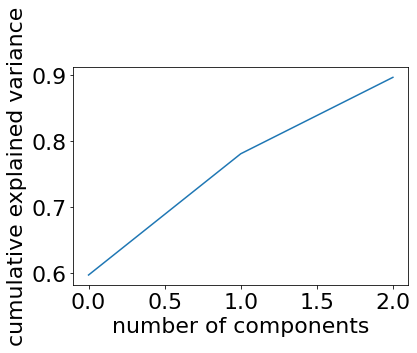

In [4]:
n = 3

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [5]:
model = IV2SLS(df.log_gdp, 
               df[['log_GFCF', 'log_wkn_population', 'constant', 'pca_1', 'pca_2']], 
               df[['pca_0']],
               df[['eci']])
results = model.fit()
results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                log_gdp   R-squared:                      0.9616
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9613
No. Observations:                 637   F-statistic:                 1.807e+04
Date:                Tue, Dec 14 2021   P-value (F-stat)                0.0000
Time:                        16:04:36   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
log_GFCF               0.8045     0.0403     19.966     0.0000      0.7256      0.8835
log_wkn_population    -0.0122     0.0140    -0.8762     0.3809     -0.0396      0.0151
constant              -7.3270     1.0112    -7.2458     0.0000     -9.3089     -5.3451
pca_1                  0.1144     0.0187     6.1103     0.0000      0.0777      0.1511
pca_2                 -0.1532     0.0273    -5.6170     0.0000     -0.2067     -0.0998
pca_0                  0.1428     0.0333     4.2834     0.0000      0.0775      0.2082
======================================================================================

Endogenous: pca_0
Instruments: eci
Robust Covariance (Heteroskedastic)
Debiased: False
"""

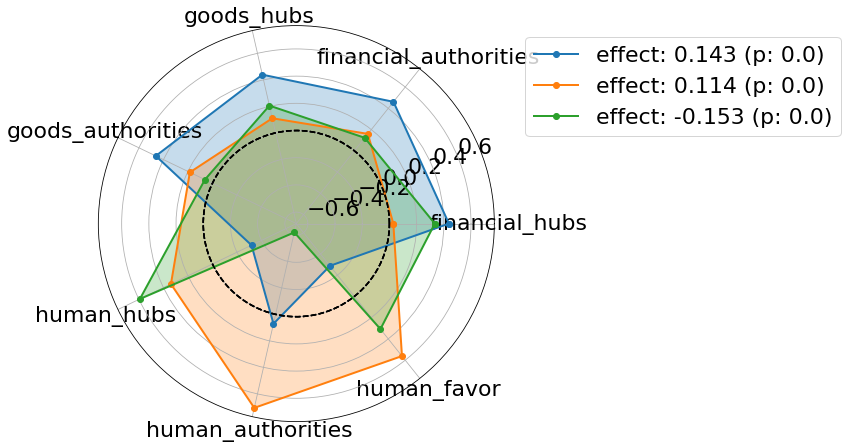

In [6]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = reduced_terms_list)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = reduced_terms_list.copy()
stats_vector = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(reduced_terms_list), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats_vector = df_radar.loc[i,reduced_terms_list]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats_vector,[stats_vector[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
    )
    ax.fill(angles, stats_vector, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'pca_results.png')
plt.savefig(save_to, transparent=False)    
plt.show()